# Modeling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.path)

['/Users/ghulamshah/Desktop/GitHub/NFL_Game_Predictor', '/Users/ghulamshah/anaconda3/envs/First/lib/python311.zip', '/Users/ghulamshah/anaconda3/envs/First/lib/python3.11', '/Users/ghulamshah/anaconda3/envs/First/lib/python3.11/lib-dynload', '', '/Users/ghulamshah/anaconda3/envs/First/lib/python3.11/site-packages']


In [3]:
# common imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

from lazypredict.Supervised import LazyClassifier

# will display all the columns in the df moving forward
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier

In [5]:
from src.data_preparation import load_csv_data_from_disk
df = load_csv_data_from_disk(file_name='transformed.csv')

In [6]:
df

,season,week,home_team,date_time,home_team_win_rate_last_1_games,home_team_win_rate_last_4_games,home_team_win_rate_last_8_games,home_team_pass_rate_last_1_games,home_team_pass_rate_last_4_games,home_team_pass_rate_last_8_games,home_team_rush_rate_last_1_games,home_team_rush_rate_last_4_games,home_team_rush_rate_last_8_games,home_team_pass_allowed_rate_last_1_games,home_team_pass_allowed_rate_last_4_games,home_team_pass_allowed_rate_last_8_games,home_team_rush_allowed_rate_last_1_games,home_team_rush_allowed_rate_last_4_games,home_team_rush_allowed_rate_last_8_games,home_team_ot_rate_last_1_games,home_team_ot_rate_last_4_games,home_team_ot_rate_last_8_games,home_team_to_rate_last_1_games,home_team_to_rate_last_4_games,home_team_to_rate_last_8_games,home_team_to_forced_rate_last_1_games,home_team_to_forced_rate_last_4_games,home_team_to_forced_rate_last_8_games,home_team_points_scored_rate_last_1_games,home_team_points_scored_rate_last_4_games,home_team_points_scored_rate_last_8_games,home_team_points_allowed_rate_last_1_games,home_team_points_allowed_rate_last_4_games,home_team_points_allowed_rate_last_8_games,home_team_1st_downs_rate_last_1_games,home_team_1st_downs_rate_last_4_games,home_team_1st_downs_rate_last_8_games,home_team_1st_downs_allowed_rate_last_1_games,home_team_1st_downs_allowed_rate_last_4_games,home_team_1st_downs_allowed_rate_last_8_games,home_team_win,away_team,away_team_win_rate_last_1_games,away_team_win_rate_last_4_games,away_team_win_rate_last_8_games,away_team_pass_rate_last_1_games,away_team_pass_rate_last_4_games,away_team_pass_rate_last_8_games,away_team_rush_rate_last_1_games,away_team_rush_rate_last_4_games,away_team_rush_rate_last_8_games,away_team_pass_allowed_rate_last_1_games,away_team_pass_allowed_rate_last_4_games,away_team_pass_allowed_rate_last_8_games,away_team_rush_allowed_rate_last_1_games,away_team_rush_allowed_rate_last_4_games,away_team_rush_allowed_rate_last_8_games,away_team_ot_rate_last_1_games,away_team_ot_rate_last_4_games,away_team_ot_rate_last_8_games,away_team_to_rate_last_1_games,away_team_to_rate_last_4_games,away_team_to_rate_last_8_games,away_team_to_forced_rate_last_1_games,away_team_to_forced_rate_last_4_games,away_team_to_forced_rate_last_8_games,away_team_points_scored_rate_last_1_games,away_team_points_scored_rate_last_4_games,away_team_points_scored_rate_last_8_games,away_team_points_allowed_rate_last_1_games,away_team_points_allowed_rate_last_4_games,away_team_points_allowed_rate_last_8_games,away_team_1st_downs_rate_last_1_games,away_team_1st_downs_rate_last_4_games,away_team_1st_downs_rate_last_8_games,away_team_1st_downs_allowed_rate_last_1_games,away_team_1st_downs_allowed_rate_last_4_games,away_team_1st_downs_allowed_rate_last_8_games,home_team_code,away_team_code
0,1994,1,Indianapolis Colts,1994-09-04 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Tennessee Titans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,30
1,1994,1,Detroit Lions,1994-09-04 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Atlanta Falcons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2,1994,1,Chicago Bears,1994-09-04 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Tampa Bay Buccaneers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,29
3,1994,1,Cincinnati Bengals,1994-09-04 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Data Cleansing

In [7]:
# convert date_time col from an object dtype to a date_time dtype
df['date_time'] = pd.to_datetime(df['date_time'])
df['date_time'] = df[('date_time')].values.astype("float64")

In [8]:
# be able to trace back to team names
di_home = dict(zip(df.home_team, df.home_team_code))
di_away = dict(zip(df.away_team, df.away_team_code))

In [9]:
df.shape

(7660, 80)

In [10]:
predictors = ['season', 'week', 'home_team_code', 'away_team_code', 'date_time', 
                'home_team_win_rate_last_1_games', 'home_team_win_rate_last_4_games', 'home_team_win_rate_last_8_games', 
                'home_team_pass_rate_last_8_games',
                'home_team_rush_allowed_rate_last_4_games', 'home_team_rush_allowed_rate_last_8_games',
                'home_team_points_scored_rate_last_1_games', 'home_team_points_scored_rate_last_4_games', 'home_team_points_scored_rate_last_8_games',
                'home_team_points_allowed_rate_last_4_games', 'home_team_points_allowed_rate_last_8_games',
                'home_team_1st_downs_rate_last_4_games', 'home_team_1st_downs_rate_last_8_games', 
                'away_team_win_rate_last_4_games', 'away_team_win_rate_last_8_games',
                'away_team_pass_rate_last_4_games', 'away_team_pass_rate_last_8_games',
                'away_team_rush_allowed_rate_last_8_games', 
                'away_team_points_scored_rate_last_4_games', 'away_team_points_scored_rate_last_8_games',
                'away_team_points_allowed_rate_last_8_games', 
                'away_team_1st_downs_rate_last_4_games', 'away_team_1st_downs_rate_last_8_games']

In [11]:
len(predictors)

28

## Splitting the Data

In [12]:
train = df[df["season"] < 2019]
test = df[df["season"] >= 2019]

In [13]:
X_train = train[predictors]
X_test = test[predictors]
y_train = train['home_team_win']
y_test = test['home_team_win']

In [14]:
X_train

,season,week,home_team_code,away_team_code,date_time,home_team_win_rate_last_1_games,home_team_win_rate_last_4_games,home_team_win_rate_last_8_games,home_team_pass_rate_last_8_games,home_team_rush_allowed_rate_last_4_games,home_team_rush_allowed_rate_last_8_games,home_team_points_scored_rate_last_1_games,home_team_points_scored_rate_last_4_games,home_team_points_scored_rate_last_8_games,home_team_points_allowed_rate_last_4_games,home_team_points_allowed_rate_last_8_games,home_team_1st_downs_rate_last_4_games,home_team_1st_downs_rate_last_8_games,away_team_win_rate_last_4_games,away_team_win_rate_last_8_games,away_team_pass_rate_last_4_games,away_team_pass_rate_last_8_games,away_team_rush_allowed_rate_last_8_games,away_team_points_scored_rate_last_4_games,away_team_points_scored_rate_last_8_games,away_team_points_allowed_rate_last_8_games,away_team_1st_downs_rate_last_4_games,away_team_1st_downs_rate_last_8_games
0,1994,1,13,30,778683600000000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994,1,10,1,778683600000000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994,1,5,29,778683600000000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994,1,6,7,778683600000000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994,1,22,15,778683600000000000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,2018,19,21,17,1547384400000000000.00,1.00,0.50,0.62,265.62,130.75,119.88,38.00,26.25,24.62,16.50,17.50,22.50,23.25,0.75,0.75,187.25,232.25,96.25,21.25,26.38,20.00,18.75,21.25
6551,2018,19,22,25,1547395200000000000.00,0.00,0.75,0.75,215.38,94.75,84.00,14.00,21.25,28.12,21.00,16.88,20.25,21.88,1.00,0.75,305.25,262.62,96.88,25.50,23.12,22.50,22.00,20.50
6552,2018,20,22,18,1547996400000000000.00,1.00,0.75,0.75,217.62,80.75,76.38,20.00,19.25,24.25,21.00,16.88,21.75,20.88,0.75,0.75,231.25,246.00,132.38,33.00,32.25,25.75,28.50,25.75
6553,2018,20,15,21,1548007200000000000.00,1.00,0.50,0.62,295.62,135.75,134.75,31.00,31.25,33.62,20.75,26.00,22.75,24.12,0.75,0.62,244.00,269.75,107.62,28.25,25.88,18.88,23.00,23.50


In [15]:
### KERNEL KEEPS CRASHING ###
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.62,0.62,0.62,0.62,0.01
GaussianNB,0.60,0.60,0.60,0.59,0.02
PassiveAggressiveClassifier,0.60,0.60,0.60,0.60,0.02
SVC,0.60,0.59,0.59,0.57,2.19
QuadraticDiscriminantAnalysis,0.60,0.59,0.59,0.57,0.02
ExtraTreesClassifier,0.59,0.58,0.58,0.58,0.67
BernoulliNB,0.59,0.58,0.58,0.58,0.02
XGBClassifier,0.59,0.58,0.58,0.58,0.22
CalibratedClassifierCV,0.59,0.58,0.58,0.56,1.86


## First Model - Hist Gradient Boosting Classifier

In [16]:
# creating the decision tree
hist_clf = HistGradientBoostingClassifier(max_depth=5, min_samples_leaf=20, max_iter=102, learning_rate=0.2, verbose=0, random_state=42)
hist_clf.fit(X_train, y_train)

HistGradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_iter=102,
                               random_state=42)

In [17]:
hist_clf_pred = hist_clf.predict(X_test)

In [18]:
# evaluating the accuracy
acc_score = accuracy_score(y_true=y_test, y_pred=hist_clf_pred)
prec_score = precision_score(y_true=y_test, y_pred=hist_clf_pred, average='micro')
#rec_score = recall_score(y_true=y_test, y_pred=hist_clf_pred, average='micro')
print('Accuracy = %s' % (acc_score))
print('Precision = %s' % (prec_score))
#print('Recall = %s' % (rec_score))

Accuracy = 0.6063348416289592
Precision = 0.6063348416289592


In [19]:
print('Accuracy: %.3f' % accuracy_score(y_test, hist_clf_pred))
print('Precision: %.3f' % precision_score(y_test, hist_clf_pred))
print('Recall: %.3f' % recall_score(y_test, hist_clf_pred))
print('F1 Score: %.3f' % f1_score(y_test, hist_clf_pred))

Accuracy: 0.606
Precision: 0.642
Recall: 0.566
F1 Score: 0.601


In [20]:
# F1 and ROC AUC scores and classification report
print('F1 Score: %.3f' % f1_score(y_test, hist_clf_pred))
print('ROC AUC Score: %.3f' % roc_auc_score(y_test, hist_clf_pred))
# Classification report
classification_rep = classification_report(y_test, hist_clf_pred)
print("Classification Report:\n", classification_rep)

F1 Score: 0.601
ROC AUC Score: 0.608
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.65      0.61       525
           1       0.64      0.57      0.60       580

    accuracy                           0.61      1105
   macro avg       0.61      0.61      0.61      1105
weighted avg       0.61      0.61      0.61      1105



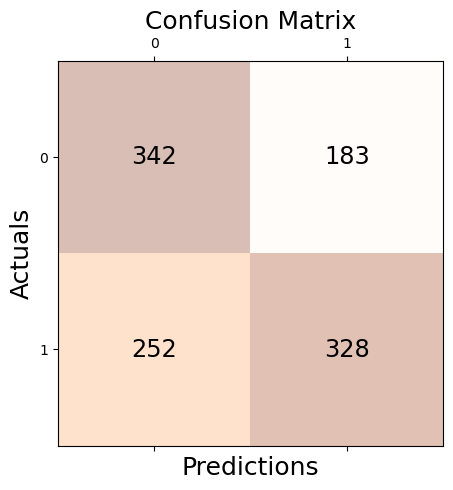

In [21]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=hist_clf_pred)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Second Model - Nearest Centroid Classifier

In [22]:
from sklearn.svm import NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ImportError: cannot import name 'NearestCentroid' from 'sklearn.svm' (/Users/ghulamshah/anaconda3/envs/First/lib/python3.11/site-packages/sklearn/svm/__init__.py)

In [174]:
nc = NearestCentroid()
nc.fit(xtrain, ytrain)

NameError: name 'NearestCentroid' is not defined